# Data Overview

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

Source: https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/

Install libraries

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Upload train and test files

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print("Train Shape:",train.shape)
print("Test Shape:", test.shape)

Train Shape: (8523, 12)
Test Shape: (5681, 11)


Combine train & test sets into 1 for data engineering and selection

In [3]:
train['Source'] = 'train'
test['Source'] = 'test'
data = pd.concat([train, test], ignore_index = True)

# Data Exploratory

### Missing Values

In [4]:
data.isnull().sum()

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
Source                          0
dtype: int64

Item_Outlet_Sales is the outcome variable, the number of mising values is equal to the test set size, therefore we don't have to impute missing values for Item_Outlet_sales. 
##### We'll only need to imput Item_Weight and Outlet_Size (1)

In [5]:
data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,Source
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,19.20,1998,OUT010,Tier 3,NaN,Grocery Store,train
4,Low Fat,NCD19,53.8614,994.7052,Household,0.000000,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train


There are both numerical and categorical variables. Now let's look at the summary of each group.

### Numeric variables

In [6]:
data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


##### Outlet_Establishment_Year should be changed to years since establishment. (2)
##### Item_Visibility should not be 0 as it does not make sense when it is sold in a store.(3)

### Categorical variables

In [7]:
categorical_var = [x for x in data.dtypes.index if data.dtypes[x] == 'object']
data[categorical_var].apply(lambda x: len(x.unique()))

Item_Fat_Content           5
Item_Identifier         1559
Item_Type                 16
Outlet_Identifier         10
Outlet_Location_Type       3
Outlet_Size                4
Outlet_Type                4
Source                     2
dtype: int64

There are 1559 prododucts, with 5 fat content, belonging to 16 categories, sold in 10 different outlets.
There are 3 outlet location types, 4 outlet sizes and 4 outlet types.
We'll exclude ID and Source from the analysis and look at the frequency of each categorical variables.

In [8]:
categorical_var = [x for x in categorical_var if x not in ['Item_Identifier', 'Outlet_Identifier', 'Source']]
for var in categorical_var:
    print('\nFrequency of Categories for variable', var)
    print(data[var].value_counts())


Frequency of Categories for variable Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for variable Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for variable Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of Categories for variable Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int6

##### Item_Fat_Content: some of "Low Fat" values miscoded as "low fat" or "LF". Same with Regular. (4)
##### There are too many product categories, we might combine them. Also, note the first 2 letters in the item_identifier above. (5)
##### May we can combine Supermarket Type2 and Type3 as fit given their small sizes compared with supermarket type 1.(6)

### Missing Values Imputation & Feature Engineering

##### 1.a. Impute Item_Weight missing values with the average weight per item based on item identifier

In [9]:
item_avg_weight = data.pivot_table(values = 'Item_Weight', index = 'Item_Identifier')
item_avg_weight.head()

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115


In [10]:
weight_missing = (data['Item_Weight'].isnull())
data.loc[weight_missing, 'Item_Weight'] = data.loc[weight_missing, 'Item_Identifier'].apply(lambda x: item_avg_weight.loc[x].Item_Weight)

data['Item_Weight'].isnull().sum()

0

##### 1.b. Impute Outlet_Size missing values with the mode of outlet size per outlet type

In [11]:
from scipy.stats import mode
outlet_size_mode = data.pivot_table(values='Outlet_Size', index='Outlet_Type', aggfunc=(lambda x: mode(x.dropna())[0]))
outlet_size_mode

C:\Users\thaoduong252\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


,Outlet_Size
Outlet_Type,
Grocery Store,Small
Supermarket Type1,Small
Supermarket Type2,Medium
Supermarket Type3,Medium


In [12]:
size_missing = (data['Outlet_Size'].isnull())
data.loc[size_missing, 'Outlet_Size']=data.loc[size_missing, 'Outlet_Type'].apply(lambda x: outlet_size_mode.loc[x].Outlet_Size)

data['Outlet_Size'].isnull().sum()

0

##### 2. Determine the years of operation of a store (the dataset is from 2013)

In [13]:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

##### 3. Modify Item Visibility (all items should have some sort of visibility) based on Item Identifier and Outlet_Size.

In [14]:
visibility_avg = data.pivot_table(values = 'Item_Visibility', index = ['Item_Identifier', 'Outlet_Size'])
visibility_avg.head(15)

Item_Visibility
Item_Identifier Outlet_Size                 
DRA12           High                0.040912
                Medium              0.040957
                Small               0.030132
DRA24           High                0.039895
                Medium              0.039939
                Small               0.049459
DRA59           High                0.127821
                Medium              0.127961
                Small               0.137022
DRB01           High                0.082171
                Medium              0.082261
                Small               0.077234
DRB13           High                0.007038
                Medium              0.004709
                Small               0.008004

In [15]:
zeros = (data['Item_Visibility'] == 0)

def visibility(x):
    return visibility_avg.loc[x[0], x[1]].Item_Visibility

data.loc[zeros, 'Item_Visibility'] = data.loc[zeros, ['Item_Identifier', 'Outlet_Size']].apply(visibility, axis = 1)
data['Item_Visibility'].describe()

count    14204.000000
mean         0.068778
std          0.049907
min          0.000000
25%          0.030386
50%          0.056378
75%          0.096225
max          0.328391
Name: Item_Visibility, dtype: float64

##### 4. Modify categories of Item_Fat_Content

In [16]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF': 'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'})
data['Item_Fat_Content'].value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

##### 5. Create a broad category of Item_Type based on the first 2 letter of Item_Identifier

In [17]:
data['Item_Type_Broad'] = data['Item_Identifier'].apply(lambda x: x[0:2])
data['Item_Type_Broad'].value_counts()

FD    10201
NC     2686
DR     1317
Name: Item_Type_Broad, dtype: int64

In [18]:
data['Item_Type_Broad'] = data['Item_Type_Broad'].replace({'FD': 'Food', 'DR': 'Drink', 'NC': 'Non-Consumable'})

Note that non-consumable products should not have a fat content. We'll change all fat-content values for non-consumable products to 'None'

In [19]:
data.loc[data['Item_Type_Broad'] == 'Non-Consumable', 'Item_Fat_Content'] = "None"
data['Item_Fat_Content'].value_counts()

Low Fat    6499
Regular    5019
None       2686
Name: Item_Fat_Content, dtype: int64

##### 6.Combine Outlet Type if the sales are very similar in Supermarket Type 2 and Supermarket Type 3

In [20]:
data.pivot_table(values = 'Item_Outlet_Sales', index = 'Outlet_Type')

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


This shows significant diffences in sales in Supermarket 2 and 3, so although there are not as many Supermarket Type 2 and 3 as Supermarket Type 1 and Grocery Store, we should keep them as is.

In [21]:
data.head(10)

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,Source,Outlet_Years,Item_Type_Broad
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.300,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,14,Food
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.920,2009,OUT018,Tier 3,Medium,Supermarket Type2,train,4,Drink
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.500,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,14,Food
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.018369,19.200,1998,OUT010,Tier 3,Small,Grocery Store,train,15,Food
4,None,NCD19,53.8614,994.7052,Household,0.000000,8.930,1987,OUT013,Tier 3,High,Supermarket Type1,train,26,Non-Consumable
5,Regular,FDP36,51.4008,556.6088,Baking Goods,0.000000,10.395,2009,OUT018,Tier 3,Medium,Supermarket Type2,train,4,Food
6,Regular,FDO10,57.6588,343.5528,Snack Foods,0.012741,13.650,1987,OUT013,Tier 3,High,Supermarket Type1,train,26,Food
7,Low Fat,FDP10,107.7622,4022.7636,Snack Foods,0.127470,19.000,1985,OUT027,Tier 3,Medium,Supermarket Type3,train,28,Food
8,Regular,FDH17,96.9726,1076.5986,Frozen Foods,0.016687,16.200,2002,OUT045,Tier 2,Small,Supermarket Type1,train,11,Food
9,Regular,FDU28,187.8214,4710.5350,Frozen Foods,0.094450,19.200,2007,OUT017,Tier 2,Small,Supermarket Type1,train,6,Food


##### Finally, one-hot coding of categorical variables

In [22]:
data = pd.get_dummies(data, columns=['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Broad'])

Drop the columns which have been converted to different types

In [23]:
data.drop(['Outlet_Establishment_Year'],axis=1,inplace=True)
data.head(10)

,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Identifier,Source,Outlet_Years,Item_Fat_Content_Low Fat,Item_Fat_Content_None,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Type_Broad_Drink,Item_Type_Broad_Food,Item_Type_Broad_Non-Consumable
0,FDA15,249.8092,3735.1380,0.016047,9.300,OUT049,train,14,1,0,...,0,1,0,0,1,0,0,0,1,0
1,DRC01,48.2692,443.4228,0.019278,5.920,OUT018,train,4,0,0,...,0,1,0,0,0,1,0,1,0,0
2,FDN15,141.6180,2097.2700,0.016760,17.500,OUT049,train,14,1,0,...,0,1,0,0,1,0,0,0,1,0
3,FDX07,182.0950,732.3800,0.018369,19.200,OUT010,train,15,0,0,...,0,0,1,1,0,0,0,0,1,0
4,NCD19,53.8614,994.7052,0.000000,8.930,OUT013,train,26,0,1,...,1,0,0,0,1,0,0,0,0,1
5,FDP36,51.4008,556.6088,0.000000,10.395,OUT018,train,4,0,0,...,0,1,0,0,0,1,0,0,1,0
6,FDO10,57.6588,343.5528,0.012741,13.650,OUT013,train,26,0,0,...,1,0,0,0,1,0,0,0,1,0
7,FDP10,107.7622,4022.7636,0.127470,19.000,OUT027,train,28,1,0,...,0,1,0,0,0,0,1,0,1,0
8,FDH17,96.9726,1076.5986,0.016687,16.200,OUT045,train,11,0,0,...,0,0,1,0,1,0,0,0,1,0
9,FDU28,187.8214,4710.5350,0.094450,19.200,OUT017,train,6,0,0,...,0,0,1,0,1,0,0,0,1,0


### Divide into test and train sets

In [24]:
dtrain = data.loc[data['Source']=="train"].copy()
dtest = data.loc[data['Source']=="test"].copy()

#Drop unnecessary columns:
dtest.drop(['Item_Outlet_Sales','Source'],axis=1,inplace=True)
dtrain.drop(['Source'],axis=1,inplace=True)

# Export to re-use for multiple sessions
dtrain.to_csv("train_modified.csv",index=False)
dtest.to_csv("test_modified.csv",index=False)

# Pre Analysis

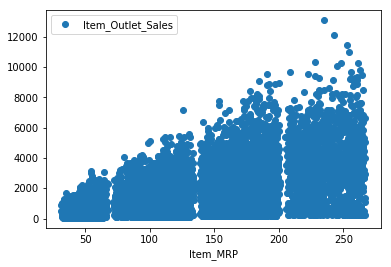

In [53]:
# Item Outlet Sales vs. Item_MRP
dtrain.plot(x='Item_MRP', y='Item_Outlet_Sales', style='o')
plt.show()

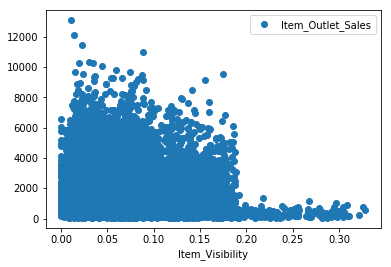

In [54]:
# Item Visibility shows an interesting relationship with Item_Outlet_Sales. 
# The more visibility does not necessary let to higher sales.
dtrain.plot(x='Item_Visibility', y='Item_Outlet_Sales', style='o')
plt.show()

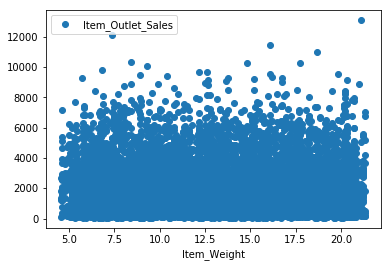

In [55]:
# There's no linear relationship between item_weight and item_outlet_sales.
dtrain.plot(x='Item_Weight', y='Item_Outlet_Sales', style='o')
plt.show()

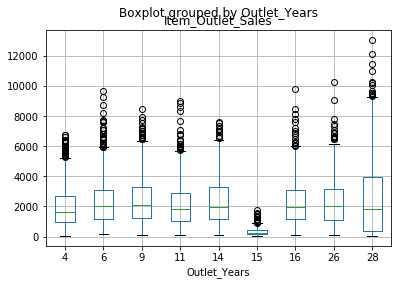

In [57]:
# There's not much difference in the sales vs. outlet years, except for those with 15 years old.
dtrain.boxplot(column='Item_Outlet_Sales', by='Outlet_Years')
plt.show()

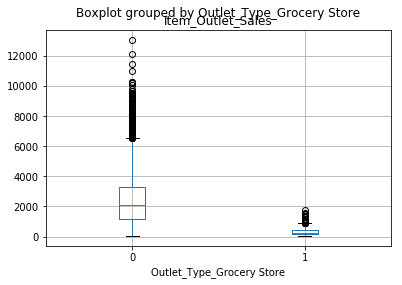

In [69]:
# Non-grocery stores tend to have higher sales
data.boxplot(column='Item_Outlet_Sales', by='Outlet_Type_Grocery Store')
plt.show()

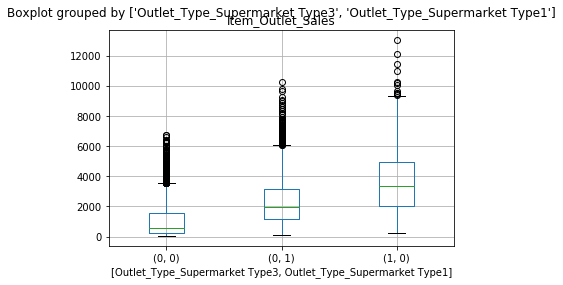

In [75]:
# Supermarket type 1 and 3 generally have higher sales.
data.boxplot(column='Item_Outlet_Sales', by=['Outlet_Type_Supermarket Type3','Outlet_Type_Supermarket Type1'] )
plt.show()

From the pre-analysis, we can see that there's not a lot of linear relationship between the independent variables and the dependent variable. Therefore, while linear regression is an easy-to-interpret, easy-to-produce method, we'll need to explore other predictive models like decision tree regressor and random forest regressor. 

# Modeling

In [25]:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier', 'Outlet_Identifier']
predictors = [x for x in dtrain.columns if x not in [target]+IDcol]

Since I'll be making many models, I'll define a generic function which takes the algorithm and data as input and runs the model, performs cross-validation, and calculates comparison metrics.

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
def modelfit(alg, dtrain, predictors, target):
    # Fit the algorithm on the train data
    alg.fit(dtrain[predictors], dtrain[target])
    
    # Predict on the training set
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    # Perform cross-validation
    cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv = 20, scoring = 'neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    # Print model report:
    print("Model Report")
    print("RMSE: %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print("CV Score: Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))    

### Baseline model: Linear regression with all features

In [27]:
from sklearn.linear_model import LinearRegression
alg1 = LinearRegression(normalize=True)
modelfit(alg1, dtrain, predictors, target)

Model Report
RMSE: 1128
CV Score: Mean - 1135 | Std - 42.47 | Min - 1079 | Max - 1216


In [28]:
predictors

['Item_MRP',
 'Item_Visibility',
 'Item_Weight',
 'Outlet_Years',
 'Item_Fat_Content_Low Fat',
 'Item_Fat_Content_None',
 'Item_Fat_Content_Regular',
 'Item_Type_Baking Goods',
 'Item_Type_Breads',
 'Item_Type_Breakfast',
 'Item_Type_Canned',
 'Item_Type_Dairy',
 'Item_Type_Frozen Foods',
 'Item_Type_Fruits and Vegetables',
 'Item_Type_Hard Drinks',
 'Item_Type_Health and Hygiene',
 'Item_Type_Household',
 'Item_Type_Meat',
 'Item_Type_Others',
 'Item_Type_Seafood',
 'Item_Type_Snack Foods',
 'Item_Type_Soft Drinks',
 'Item_Type_Starchy Foods',
 'Outlet_Location_Type_Tier 1',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Location_Type_Tier 3',
 'Outlet_Size_High',
 'Outlet_Size_Medium',
 'Outlet_Size_Small',
 'Outlet_Type_Grocery Store',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type2',
 'Outlet_Type_Supermarket Type3',
 'Item_Type_Broad_Drink',
 'Item_Type_Broad_Food',
 'Item_Type_Broad_Non-Consumable']

### Feature Selection

Since the data set includes both nominal (0,1) and continous variables, we need to re-scale the data before running random forest for feature selection. The reason is that random forest tends to give higher weights to variables with bigger range.

In [29]:
from sklearn.preprocessing import MinMaxScaler
MinMax = MinMaxScaler(feature_range= (0,1))
X = pd.DataFrame(MinMax.fit_transform(dtrain[predictors]))
X.columns = predictors
Y = dtrain[target]
Y.columns = 'Item_Outlet_Sales'
X.shape

(8523, 36)

In [30]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X, Y)

Sr = pd.Series(model.feature_importances_,index = X.columns)
Sr.sort_values(inplace = True, ascending = False)
print(Sr)

Item_MRP                           0.417386
Outlet_Type_Grocery Store          0.182276
Item_Visibility                    0.069176
Item_Weight                        0.062159
Outlet_Type_Supermarket Type3      0.055481
Outlet_Years                       0.045820
Item_Type_Snack Foods              0.011206
Item_Type_Fruits and Vegetables    0.011124
Item_Fat_Content_Low Fat           0.010544
Item_Fat_Content_Regular           0.010417
Item_Type_Dairy                    0.009592
Item_Type_Frozen Foods             0.008501
Item_Type_Canned                   0.007721
Outlet_Location_Type_Tier 1        0.007513
Outlet_Location_Type_Tier 2        0.007416
Item_Type_Baking Goods             0.007238
Outlet_Size_Small                  0.007026
Outlet_Size_Medium                 0.006071
Item_Type_Meat                     0.005922
Item_Type_Breads                   0.004969
Item_Type_Broad_Drink              0.004896
Item_Type_Household                0.004662
Item_Type_Health and Hygiene    

In [31]:
X_selected = Sr[0:22].index.tolist()

In [42]:
X_selected2 = Sr[0:15].index.tolist()

### Linear Regression

In [32]:
alg2 = LinearRegression(normalize=True)
modelfit(alg2, dtrain, X_selected, target)

Model Report
RMSE: 1128
CV Score: Mean - 1131 | Std - 42.43 | Min - 1076 | Max - 1213


In [43]:
alg3 = LinearRegression(normalize=True)
modelfit(alg3, dtrain, X_selected2, target)

Model Report
RMSE: 1130
CV Score: Mean - 1132 | Std - 42.16 | Min - 1075 | Max - 1211


### Ridge Regression Model

In [44]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid = {"alpha": [0.01, 0.05, 0.1]}
grid_search = GridSearchCV(Lasso(normalize = True), param_grid, cv = 5)
alg4 = grid_search.fit(dtrain[X_selected], dtrain[target])

#alg3 = Lasso(alpha=0.05,normalize=True)
modelfit(alg4, dtrain, X_selected, target)

Model Report
RMSE: 1129
CV Score: Mean - 1131 | Std - 42.36 | Min - 1075 | Max - 1211


In [45]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid = {"alpha": [0.01, 0.05, 0.1]}
grid_search = GridSearchCV(Lasso(normalize = True), param_grid, cv = 5)
alg5 = grid_search.fit(dtrain[X_selected2], dtrain[target])

modelfit(alg5, dtrain, X_selected2, target)

Model Report
RMSE: 1131
CV Score: Mean - 1132 | Std - 42.81 | Min - 1075 | Max - 1212


### Decision Tree Model

In [46]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'max_features':[None,'auto', 'log2'], 'max_depth':[5,10,15,20,50], 'min_samples_leaf':[25,50,75,100,125]}

grid_search = GridSearchCV(DecisionTreeRegressor(random_state = 10), param_grid, cv=5)
alg6 = grid_search.fit(dtrain[X_selected], dtrain[target])

modelfit(alg6, dtrain, X_selected, target)

Model Report
RMSE: 1074
CV Score: Mean - 1088 | Std - 45.46 | Min - 1008 | Max - 1171


In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'max_features':[None,'auto', 'log2'], 'max_depth':[5,10,15,20,50], 'min_samples_leaf':[25,50,75,100,125]}

grid_search = GridSearchCV(DecisionTreeRegressor(random_state = 10), param_grid, cv=5)
alg7 = grid_search.fit(dtrain[X_selected2], dtrain[target])

modelfit(alg7, dtrain, X_selected2, target)

Model Report
RMSE: 1074
CV Score: Mean - 1088 | Std - 45.46 | Min - 1008 | Max - 1171


### Random Forest Model

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_grid = {"max_depth": [ 10, 15],
              "max_features": sp_randint(1, 20),
              "min_samples_split": sp_randint(2, 50),
              "min_samples_leaf": sp_randint(1, 100),
              "bootstrap": [True, False]}
random_search = RandomizedSearchCV(RandomForestRegressor(n_estimators=400), param_grid, n_iter=20, random_state=0,n_jobs=-1)

alg8 = random_search.fit(dtrain[X_selected], dtrain[target])

modelfit(alg8, dtrain, X_selected, target)

Model Report
RMSE: 1052
CV Score: Mean - 1079 | Std - 43.59 | Min - 1015 | Max - 1159


In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_grid = {"max_depth": [ 10, 15],
              "max_features": sp_randint(1, 15),
              "min_samples_split": sp_randint(2, 50),
              "min_samples_leaf": sp_randint(1, 100),
              "bootstrap": [True, False]}
random_search = RandomizedSearchCV(RandomForestRegressor(n_estimators=400), param_grid, n_iter=20, random_state=0,n_jobs=-1)

alg9 = random_search.fit(dtrain[X_selected2], dtrain[target])

modelfit(alg9, dtrain, X_selected2, target)

Model Report
RMSE: 1048
CV Score: Mean - 1081 | Std - 42.61 | Min - 1014 | Max - 1160


# Conclusion

The best performances are Random Forest alg8 and alg9. Now, let's predict the sales on the test set.

In [41]:
dtest[target] = alg8.predict(dtest[X_selected])

# Export submission file
IDcol.append(target)
submission = pd.DataFrame({x: dtest[x] for x in IDcol})
submission.to_csv("submission.csv", index = False)

In [51]:
dtest[target] = alg9.predict(dtest[X_selected2])

# Export submission file
IDcol.append(target)
submission2 = pd.DataFrame({x: dtest[x] for x in IDcol})
submission2.to_csv("submission2.csv", index = False)

My submission2 has a slightly higher score than submission1 on the test set (rank #527)

### Understand the properties of products and stores which play a key role in increasing sales.

In [93]:
# Get numerical feature importances
importances = list(alg9.best_estimator_.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_selected2, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Item_MRP             Importance: 0.55
Variable: Outlet_Type_Grocery Store Importance: 0.29
Variable: Outlet_Type_Supermarket Type3 Importance: 0.08
Variable: Outlet_Years         Importance: 0.06
Variable: Item_Visibility      Importance: 0.01
Variable: Item_Weight          Importance: 0.01
Variable: Item_Type_Snack Foods Importance: 0.0
Variable: Item_Type_Fruits and Vegetables Importance: 0.0
Variable: Item_Fat_Content_Low Fat Importance: 0.0
Variable: Item_Fat_Content_Regular Importance: 0.0
Variable: Item_Type_Dairy      Importance: 0.0
Variable: Item_Type_Frozen Foods Importance: 0.0
Variable: Item_Type_Canned     Importance: 0.0
Variable: Outlet_Location_Type_Tier 1 Importance: 0.0
Variable: Outlet_Location_Type_Tier 2 Importance: 0.0


At the top of the list is Item_MRP, list price of the product. This tells us the best predictor of the sales of one product is the retail price of itself, a rather intuitive finding. The second and third most important factors iare the type of the outlets. From our pre-analysis, we can tell that products sold in supermarket type 3 will have a higher sales compared with those sold in a grocery store. Outlet years of establishment have some effect on the sales, considering how much popularity it gains within the community.

Let’s quickly make a random forest with only the four most important variables.

In [98]:
# Extract the two most important features
important = ['Item_MRP', 'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type3', 'Outlet_Years']
# Train the random forest
param_grid = {"max_depth": [ 10, 15],
              "max_features": sp_randint(1, 4),
              "min_samples_split": sp_randint(2, 50),
              "min_samples_leaf": sp_randint(1, 100),
              "bootstrap": [True, False]}
random_search = RandomizedSearchCV(RandomForestRegressor(n_estimators=400), param_grid, n_iter=20, random_state=0,n_jobs=-1)

alg10 = random_search.fit(dtrain[important], dtrain[target])
modelfit(alg10, dtrain, important, target)

Model Report
RMSE: 1051
CV Score: Mean - 1078 | Std - 44.55 | Min - 1009 | Max - 1164


With only 4 variables, this model has a slightly higher RMSE than the previous model, however, the difference between RMSE and CV score is also smaller, which shows that it has reduced overfitting.

In [99]:
dtest[target] = alg10.predict(dtest[important])

# Export submission file
IDcol.append(target)
submission3 = pd.DataFrame({x: dtest[x] for x in IDcol})
submission3.to_csv("submission3.csv", index = False)

My submission3 turns out to be my best performance on the test set (rank #251)